# Digit recognizer

In [9]:
### Importing libraries
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn import metrics
import tensorflow as tf
from time import time
tf.logging.set_verbosity(tf.logging.INFO) # DEBUG,WARN,INFO,FATAL,ERROR

pd.options.display.max_rows = 10
pd.options.display.float_format = '{:.1f}'.format

In [2]:
### Importing MNIST dataset
train=pd.read_csv("train.csv")
test=pd.read_csv("test.csv")

In [3]:
### Splitting the training data
evl=train.iloc[0:100,:]
evl2=train.iloc[100:200,:]

### Splitting labels and features
evl_l=evl["label"]
evl_f=evl.iloc[:,1:]

evl2_l=evl2["label"]
evl2_f=evl2.iloc[:,1:]

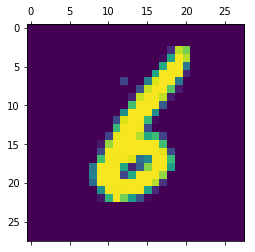

In [4]:
### Showing random example
random=np.random.randint(len(evl_f)-1)
_, ax = plt.subplots()
ax.matshow(evl_f.iloc[random,:].values.reshape(28, 28))
ax.grid(False)

### Convolutional neural network

In [18]:
input_layer=[]

In [20]:
conv1=tf.layers.conv2d(inputs=input_layer,filters=1,kernel_size=(3,3),strides=(1,1),padding="valid",activation=tf.nn.relu)

AttributeError: 'list' object has no attribute 'dtype'

In [22]:
feature_column=[tf.feature_column.numeric_column(key="pixels",shape=[28,28])]

In [ ]:
def my_model():

In [ ]:
clf=tf.estimator.Estimator(model_fn=my_model)

In [ ]:
clf.train(input_fn=create_training_input_fn(features,labels,batch_size,epochs))

### Linear classifier

In [5]:
def construct_feature_columns():
    return set([tf.feature_column.numeric_column("pixels",shape=784)])

In [6]:
def create_training_input_fn(features2,labels2,batch_size,epochs=None):
    def _input_fn():
        idx=np.random.permutation(features2.index.values)
        features=features2.reindex(idx)
        features={"pixels":features}
        labels=np.array(labels2[idx])
        ds=tf.data.Dataset.from_tensor_slices((features,labels))
        ds=ds.batch(batch_size).repeat(epochs)
        ds=ds.shuffle(40000)
        
        feature_batch,label_batch=ds.make_one_shot_iterator().get_next()
        return feature_batch,label_batch
    return _input_fn

In [7]:
def create_predict_input_fn(features2,labels2,batch_size):
    def _input_fn():
        features={"pixels":features2}
        labels=np.array(labels2)
        
        ds=tf.data.Dataset.from_tensor_slices((features,labels))
        ds=ds.batch(batch_size)
        
        feature_batch,label_batch=ds.make_one_shot_iterator().get_next()
        return feature_batch,label_batch
    return _input_fn

In [8]:
def train_linear_classifier(train_f,train_l,pred_f,pred_l,batch_size,steps,learning_rate,periods):
    training_input_fn=create_training_input_fn(train_f,train_l,batch_size=batch_size)
    predict_input_fn=create_predict_input_fn(evl2_f,evl2_l,batch_size=1)
    a=time()
    optimizer=tf.train.AdagradOptimizer(learning_rate=learning_rate)
    classifier=tf.estimator.LinearClassifier(feature_columns=construct_feature_columns(), 
                                         n_classes=10, 
                                         optimizer=optimizer,
                                         config=tf.estimator.RunConfig(keep_checkpoint_max=1))
    steps_per=steps/periods
    print("Time to create classifier: %f" % (time()-a))
    for i in range(periods):
        classifier.train(input_fn=training_input_fn,steps=steps_per)
        print("Time to train: %f" %(time()-a))
        pred=classifier.predict(input_fn=predict_input_fn)
        pred2=np.array([item["class_ids"][0] for item in pred])
        print("Time to predict: %f" %(time()-a))
        
        print(metrics.accuracy_score(np.array(evl2_l),pred2))
    
    return classifier

In [11]:
classifier=train_linear_classifier(train_f=evl_f,
                                   train_l=evl_l,
                                   pred_f=evl2_f,
                                   pred_l=evl2_l,
                                   batch_size=30,
                                   steps=500,
                                   learning_rate=0.01,
                                   periods=4)

INFO:tensorflow:Using config: {'_model_dir': 'C:\\Users\\Steven\\AppData\\Local\\Temp\\tmpkvradeen', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': None, '_keep_checkpoint_max': 1, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x000002D1D0E79DD8>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}
Time to create classifier: 0.062502
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 1 into C:\Users\Steven\App